# Modeling for Mortality Predictions from Diagnosis & Discharge Texts

### GitHub repo link to jupyter file: https://github.com/UT-Austin-MSAI-Program/ai-in-healthcare-ai395t/blob/main/hw5-ml-dl/mortality_model_pivot.ipynb

## Import Libraries

In [ ]:
# Special installs
%pip install torch
%pip install spacy
%pip install imbalanced-learn
!python -m spacy download en_core_web_md

In [ ]:
# Install necessary packages
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import logging
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from nltk import word_tokenize
import string
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import vstack

## Load MIMIC III Data

In [3]:
# Logging configuration
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", handlers=[logging.StreamHandler()])

# Constants and Data Loading
MIMIC_3_DIR = '../mimic/mimic-iii-clinical-database-1.4'
diagnoses_df = pd.read_csv(f'{MIMIC_3_DIR}/DIAGNOSES_ICD.csv').set_index('ROW_ID').rename(columns=lambda x: x.lower())
notes_df = pd.read_csv(f'{MIMIC_3_DIR}/NOTEEVENTS.csv', low_memory=False).set_index('ROW_ID').rename(columns=lambda x: x.lower())
patients_df = pd.read_csv(f'{MIMIC_3_DIR}/PATIENTS.csv').set_index('ROW_ID').rename(columns=lambda x: x.lower())
diagnoses_labels_df = pd.read_csv(f'{MIMIC_3_DIR}/D_ICD_DIAGNOSES.csv').set_index('ROW_ID').rename(columns=lambda x: x.lower())

## Clean Up notes_df Before Merge

In [4]:
# Show # of records
print(notes_df.shape)
# Count unique text records
print(notes_df['text'].nunique())
# Drop duplicates
notes_df = notes_df.drop_duplicates(subset=['text'])
print(notes_df.shape)

(2083180, 10)
2023185
(2023185, 10)


## Dataframe Merge Magic (Combine it all into an easy-to-use resource)

In [5]:
# Merge diagnoses and labels, keeping necessary columns
diagnoses_labels_n_codes_df = diagnoses_df[['subject_id', 'icd9_code']].merge(diagnoses_labels_df[['icd9_code', 'short_title']], on='icd9_code', how='inner')

# Merge filtered patients with diagnoses and labels
patient_diagnoses_df = patients_df[['subject_id', 'gender', 'expire_flag']].merge(diagnoses_labels_n_codes_df, on='subject_id', how='inner')

# Filter and merge mortality data
patient_diagnoses_notes_df = patient_diagnoses_df.merge(notes_df[['subject_id', 'text']], on='subject_id', how='inner')

## Ensure No Nulls (Needed for feeding model later)

In [6]:
# check for nan values
patient_diagnoses_notes_df.isnull().sum()

subject_id     0
gender         0
expire_flag    0
icd9_code      0
short_title    0
text           0
dtype: int64

## Aggregrate short_titles Under subject_id

In [7]:
data_df = (
    patient_diagnoses_notes_df
    .groupby(['subject_id', 'gender', 'expire_flag', 'text'], as_index=False)
    .agg({
        'short_title': lambda x: ' '.join(x.astype(str))
    })
    .rename(columns={
        'short_title': 'concat_short_titles'
    })
)

## Aggregrate text Under subject_id

In [8]:
data_df = (
    data_df
    .groupby(['subject_id', 'gender', 'expire_flag', 'concat_short_titles'], as_index=False)
    .agg({
        'text': lambda x: ' '.join(x.astype(str))
    })
    .rename(columns={
        'text': 'concat_text'
    })
)

## Combine text fields

In [9]:
data_df['full_text'] = data_df['concat_short_titles'] + ' ' + data_df['concat_text']

In [10]:
# target_df.head()
print(data_df['expire_flag'].value_counts())

expire_flag
0    30601
1    15541
Name: count, dtype: int64


In [11]:
print(data_df['subject_id'].nunique())
print(data_df.shape)

46142
(46142, 6)


## Tokenize Diagnosis & Discharge Text

In [13]:
'''
Defines list of chars to remove, leaving empty space.
Cleans and converts text to lowercase.
Tokenizes text.
'''
def tokenizer_better(text):
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also', 'who', 'r', 't',
                'd', 'l', 'x', 'dl', 'k', 'rr', 'q']

'''
Limits vocab to 3000 for feature matrix size.
Tokenizes text using better tokenizer.
Removes stopwords.
Selects 1000 rows at random from data_df to fit the vectorizer.
'''
vect = CountVectorizer(max_features = 3000,
                       tokenizer = tokenizer_better,
                       stop_words = stop_words)
sample_text = data_df['full_text'].sample(1000)
vect.fit(sample_text)


/Users/jefdewitt/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_features=3000,
                stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on',
                            'in', 'for', 'name', 'is', 'patient', 's', 'he',
                            'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am',
                            'were', 'you', 'pt', 'pm', 'by', 'be', 'had', ...],
                tokenizer=<function tokenizer_better at 0x5b88445e0>)

## Charting the Most Common Words

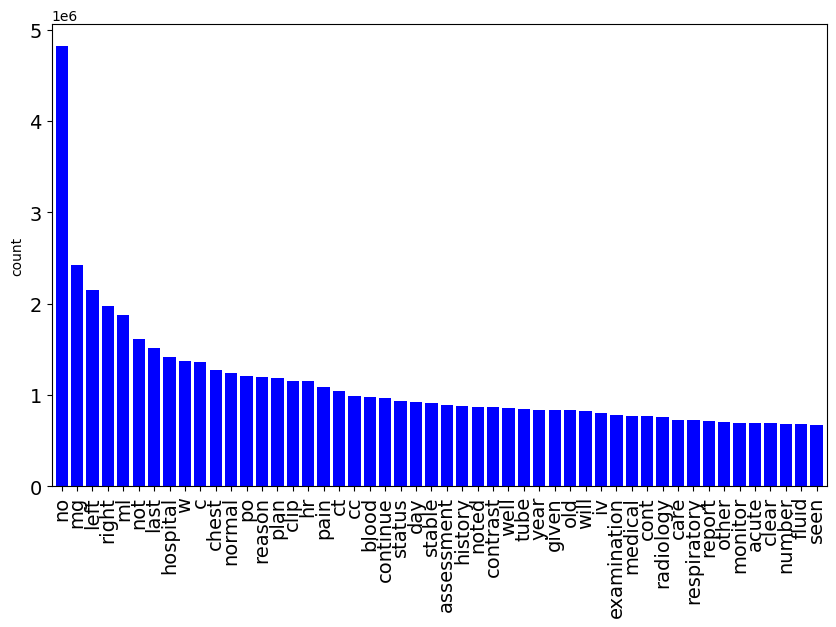

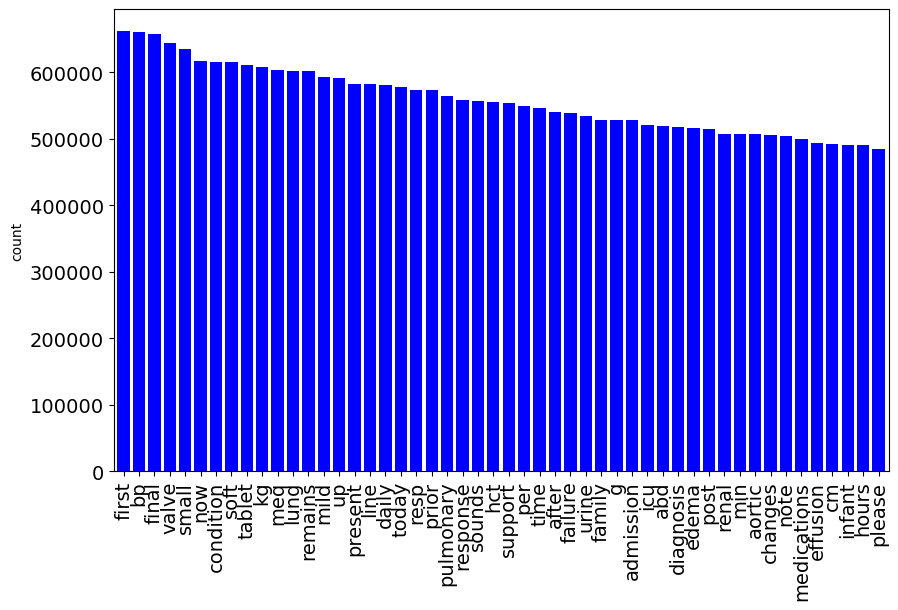

In [14]:
neg_doc_matrix = vect.transform(data_df[data_df['expire_flag'] == 0].full_text) # transform to document-term matrix
pos_doc_matrix = vect.transform(data_df[data_df['expire_flag'] == 1].full_text) 
neg_tf = np.sum(neg_doc_matrix,axis=0) # get total term frequencies
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf)) # convert matrix to array
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names_out()).transpose() # Create a dataframe
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive'] # Add a column for total term frequencies
term_freq_df.sort_values(by='total', ascending=False).iloc[:10] # Sort by total term frequency

# Create a series from the sparse matrix & plot the top 50 words, then the next 50
d = pd.Series(term_freq_df.total,
              index = term_freq_df.index).sort_values(ascending=False)
ax = d[:50].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90, color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()
ax = d[50:100].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

## Shapes Sanity Check

In [46]:
print(neg_doc_matrix.shape)
print(pos_doc_matrix.shape)

# Combine negative and positive samples into a single feature matrix
feature_matrix = vstack([neg_doc_matrix, pos_doc_matrix])
# Create labels: 0 for negative samples, 1 for positive samples
label_vector = np.hstack([
    np.zeros(neg_doc_matrix.shape[0]), 
    np.ones(pos_doc_matrix.shape[0])
])

# Ensure consistent splitting
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, label_vector, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

(30601, 3000)
(15541, 3000)
X_train shape: (36913, 3000)
y_train shape: (36913,)
X_test shape: (9229, 3000)
y_test shape: (9229,)


## Feature Importance and Stopwords

/Users/jefdewitt/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


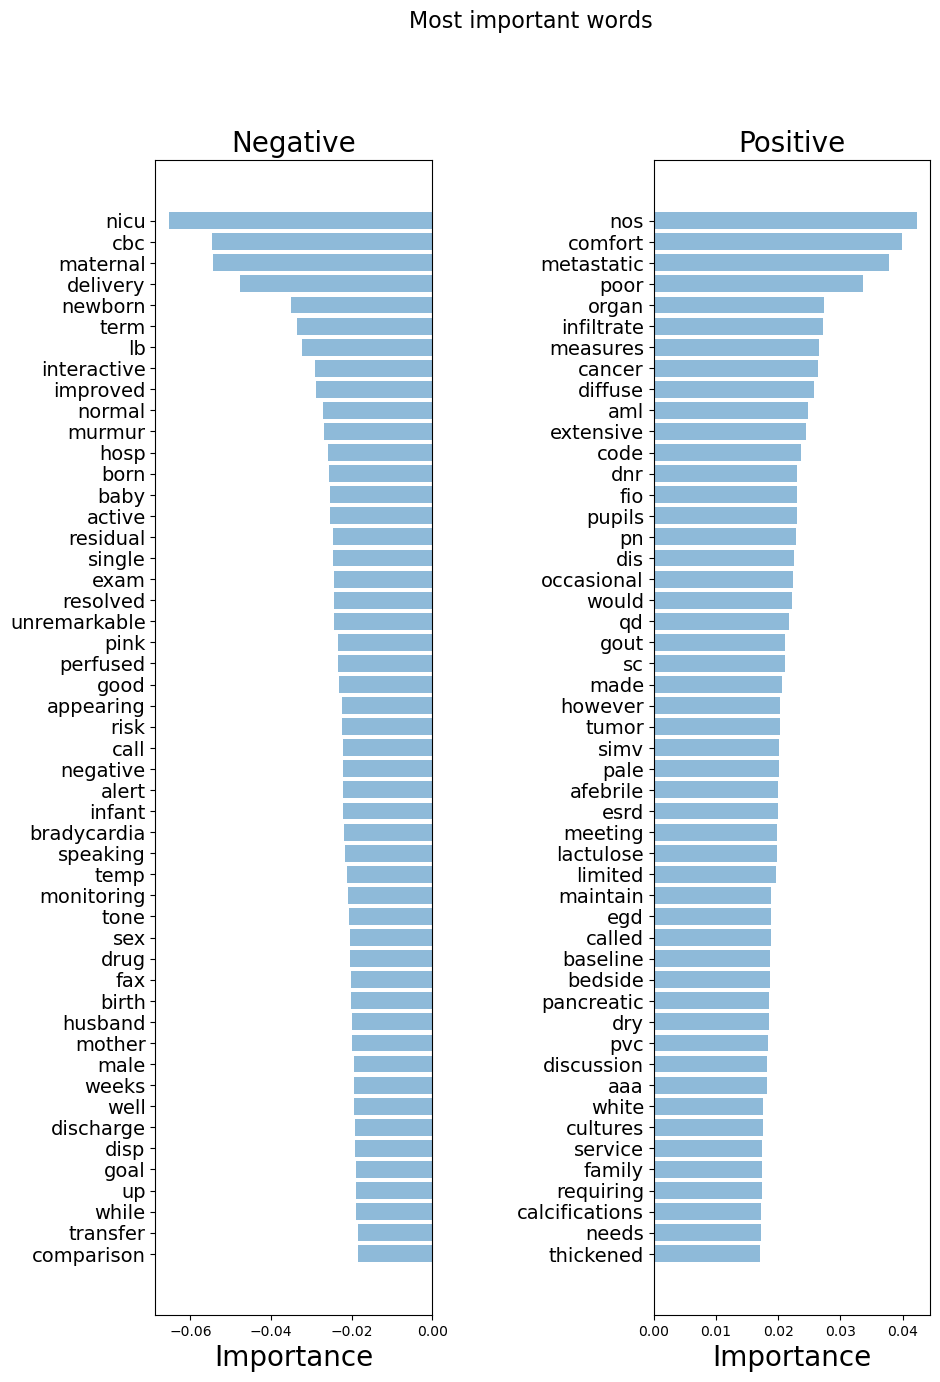

In [47]:
X_train_tf = X_train
X_valid_tf = X_test
y_train_tf = y_train
y_valid_tf = y_test

# logistic regression
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    fig = plt.figure(figsize=(10, 15))

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplots_adjust(wspace=0.8)
    plt.show()


importance = get_most_important_features(vect, clf, 50)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words")

## Machine Learning Comparison (3-Model) 


Logistic Regression
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      6121
           1       0.74      0.85      0.79      3108

    accuracy                           0.85      9229
   macro avg       0.83      0.85      0.84      9229
weighted avg       0.86      0.85      0.85      9229

AUC: 0.9282584040385052

Decision Tree
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      6121
           1       0.68      0.75      0.71      3108

    accuracy                           0.79      9229
   macro avg       0.77      0.78      0.78      9229
weighted avg       0.80      0.79      0.80      9229

AUC: 0.8548281576789991


/Users/jefdewitt/miniconda3/envs/my_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



MLP
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      6121
           1       0.78      0.74      0.76      3108

    accuracy                           0.84      9229
   macro avg       0.83      0.82      0.82      9229
weighted avg       0.84      0.84      0.84      9229

AUC: 0.9153589547724492


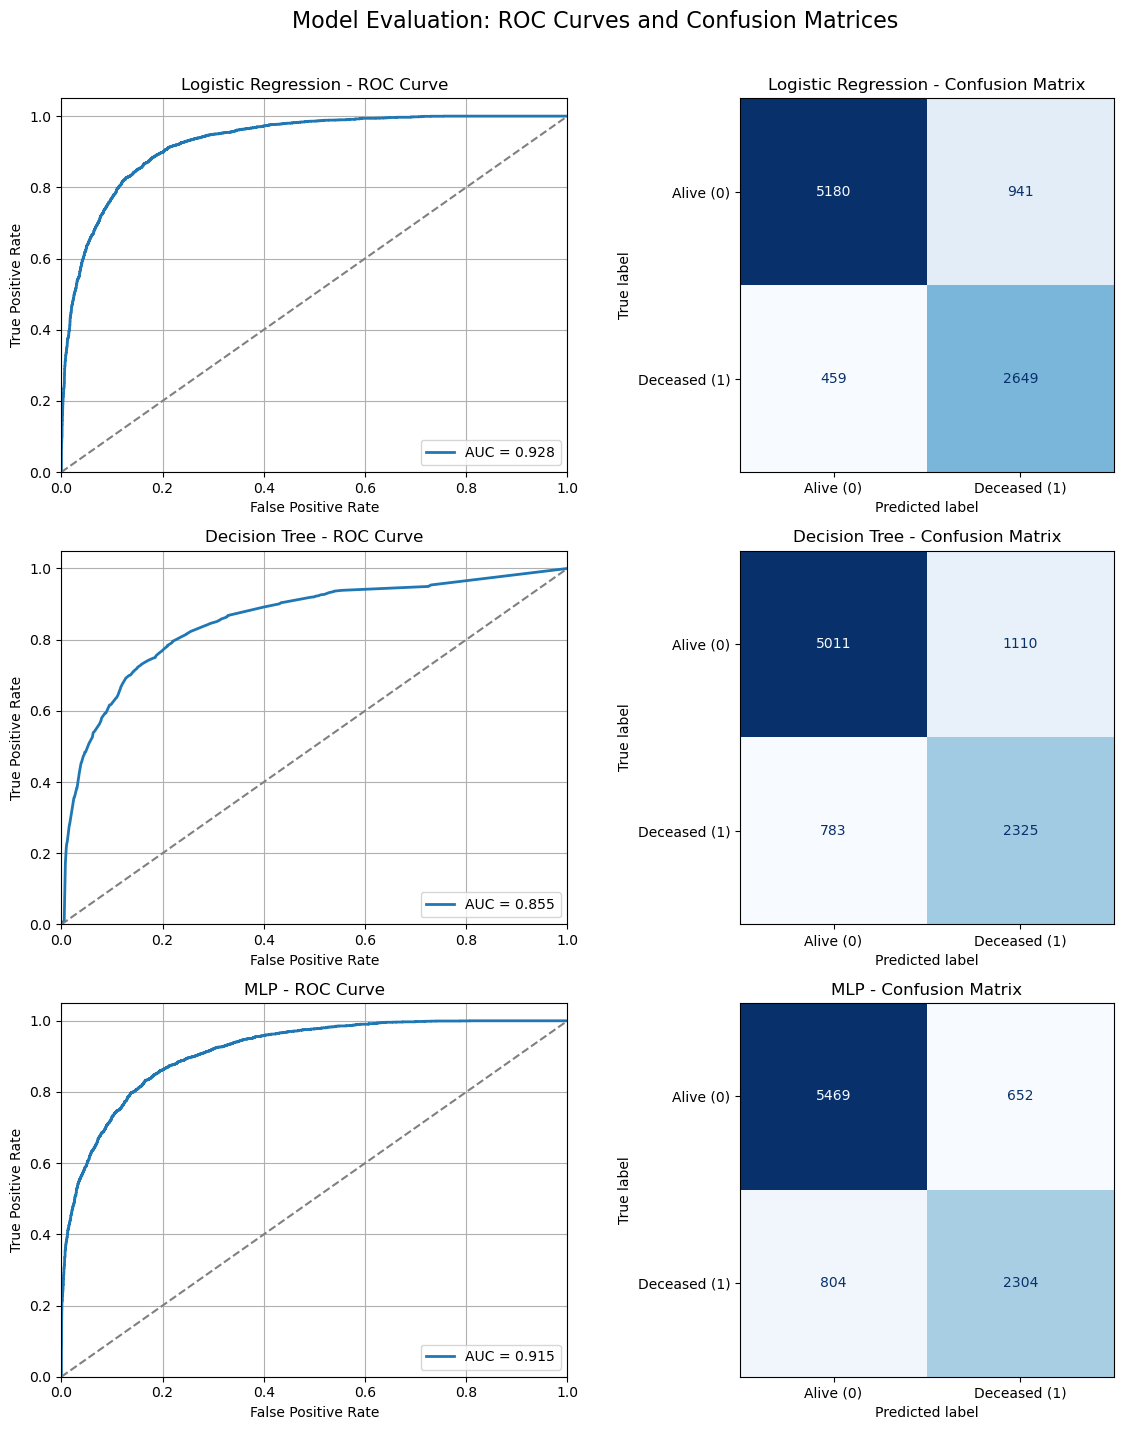

In [23]:
# Vectorize
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(data_df['full_text'])
y = data_df['expire_flag']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, class_weight='balanced'),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=100)
}

# Setup plot layout: 3 rows x 2 columns (ROC on left, Conf Mat on right)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
fig.suptitle("Model Evaluation: ROC Curves and Confusion Matrices", fontsize=16)

# Loop through models and plot
for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_proba))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    ax_roc = axes[i, 0]
    ax_roc.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
    ax_roc.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title(f'{name} - ROC Curve')
    ax_roc.legend(loc='lower right')
    ax_roc.grid(True)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Alive (0)', 'Deceased (1)'])
    disp.plot(ax=axes[i, 1], values_format='d', cmap='Blues', colorbar=False)
    axes[i, 1].set_title(f'{name} - Confusion Matrix')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


## Custom Multi-Layer Perceptron Model for Binary Classification

In [24]:
# Model Definition
class MortalityPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MortalityPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
        if input_size != output_size:
            self.skip = nn.Linear(input_size, output_size)
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        return self.skip(x) + self.model(x)

## Model Parameters & Setup

In [ ]:
input_size = X.shape[1]
hidden_size = 128
output_size = 2  # Binary classification

device = torch.device("mps" if torch.mps.is_available() else "cpu")
model = MortalityPredictor(input_size, hidden_size, output_size).to(device)

# Print shapes for debugging
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (36913, 3000)
y_train shape: (36913,)


## Train/Val/Test Split

In [ ]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# Input matrices (X_train, etc.) are sparse, convert them to dense first
X_train_sub_tensor = torch.tensor(X_train_sub.toarray(), dtype=torch.float32) # Ensures a well-formed ndarray
X_val_tensor       = torch.tensor(X_val.toarray(), dtype=torch.float32)
X_test_tensor      = torch.tensor(X_test.toarray(), dtype=torch.float32)

y_train_sub_tensor = torch.tensor(y_train_sub.values, dtype=torch.long) # Ensures a well-formed ndarray
y_val_tensor       = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor      = torch.tensor(y_test.values, dtype=torch.long)

batch_size = 32

train_loader = DataLoader(TensorDataset(X_train_sub_tensor, y_train_sub_tensor), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)


## Optimizer, Scheduler, Loss

In [33]:
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
scheduler = ExponentialLR(optimizer, gamma=0.9)
criterion = nn.CrossEntropyLoss()

## Training with Validation

In [34]:
# Auto-saving best model checkpoint
best_val_loss = float('inf')
best_model_path = "best_model.pt"

num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == targets).sum().item()
        total += targets.size(0)
    train_acc = correct / total
    train_losses.append(total_loss)
    train_accuracies.append(train_acc)

    # === Validation ===
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            v_loss = criterion(val_outputs, val_targets)
            val_loss += v_loss.item()
            val_correct += (val_outputs.argmax(dim=1) == val_targets).sum().item()
            val_total += val_targets.size(0)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Checkpoint if validation improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model at epoch {epoch+1} (Val Loss: {val_loss:.4f})")
        
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Saved new best model at epoch 1 (Val Loss: 49.6557)
Epoch 1/10, Train Loss: 558.9785, Train Acc: 0.7164, Val Loss: 49.6557, Val Acc: 0.8169
Saved new best model at epoch 2 (Val Loss: 42.4099)
Epoch 2/10, Train Loss: 394.2843, Train Acc: 0.8385, Val Loss: 42.4099, Val Acc: 0.8405
Saved new best model at epoch 3 (Val Loss: 40.6528)
Epoch 3/10, Train Loss: 340.9090, Train Acc: 0.8616, Val Loss: 40.6528, Val Acc: 0.8445
Saved new best model at epoch 4 (Val Loss: 40.2369)
Epoch 4/10, Train Loss: 307.1182, Train Acc: 0.8756, Val Loss: 40.2369, Val Acc: 0.8467
Saved new best model at epoch 5 (Val Loss: 40.2362)
Epoch 5/10, Train Loss: 280.4510, Train Acc: 0.8875, Val Loss: 40.2362, Val Acc: 0.8502
Epoch 6/10, Train Loss: 257.1644, Train Acc: 0.8980, Val Loss: 40.3574, Val Acc: 0.8505
Epoch 7/10, Train Loss: 234.8533, Train Acc: 0.9105, Val Loss: 41.1643, Val Acc: 0.8467
Epoch 8/10, Train Loss: 212.2502, Train Acc: 0.9221, Val Loss: 41.7310, Val Acc: 0.8475
Epoch 9/10, Train Loss: 196.8536, Tr

## Evaluation

In [35]:
# Load best model before test evaluation
model.load_state_dict(torch.load(best_model_path))
print("Restored best model for evaluation.")

model.eval()
correct, total = 0, 0
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)[:, 1]
        preds = outputs.argmax(dim=1)

        correct += (preds == targets).sum().item()
        total += targets.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_accuracy = correct / total
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
print("\nCustom PyTorch Model - Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Alive (0)', 'Deceased (1)']))


Restored best model for evaluation.

✅ Test Accuracy: 0.8555

Custom PyTorch Model - Classification Report:
              precision    recall  f1-score   support

   Alive (0)       0.89      0.89      0.89      6121
Deceased (1)       0.79      0.78      0.78      3108

    accuracy                           0.86      9229
   macro avg       0.84      0.84      0.84      9229
weighted avg       0.86      0.86      0.86      9229



## Performance Metrics

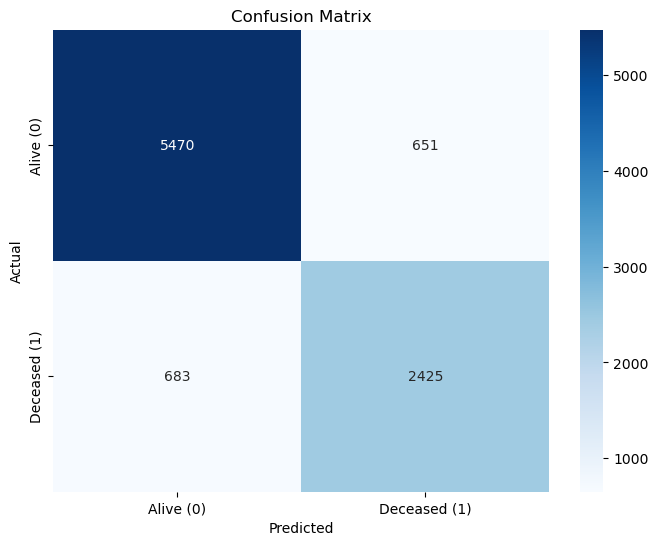

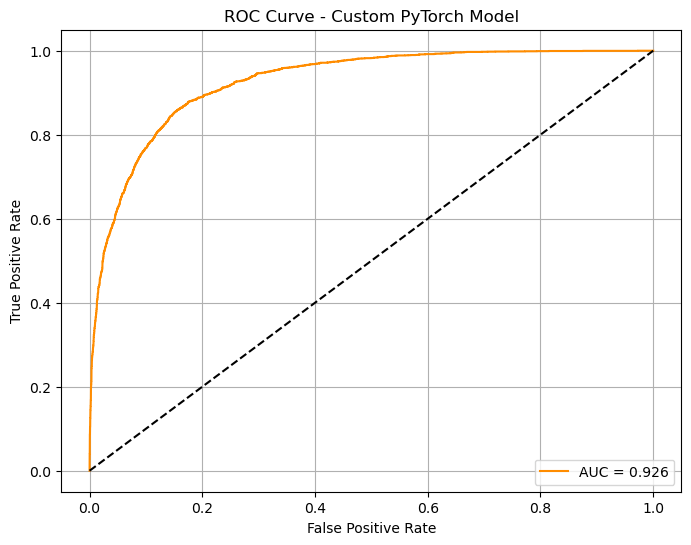

In [36]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Alive (0)', 'Deceased (1)'],
            yticklabels=['Alive (0)', 'Deceased (1)'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Custom PyTorch Model")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Convergence

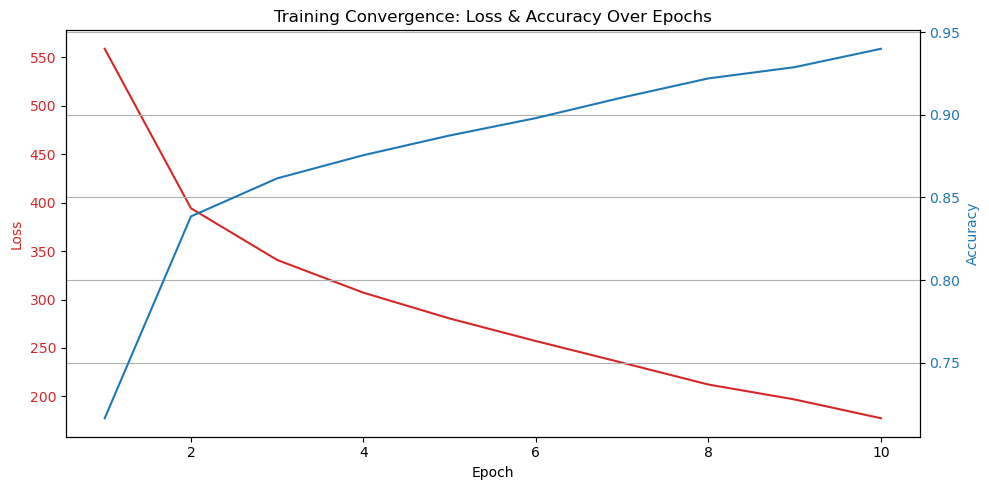

In [37]:
epochs = range(1, num_epochs + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Loss
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, train_losses, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Plot Accuracy on second y-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(epochs, train_accuracies, color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Title & Legends
plt.title("Training Convergence: Loss & Accuracy Over Epochs")
fig.tight_layout()
plt.grid(True)
plt.show()


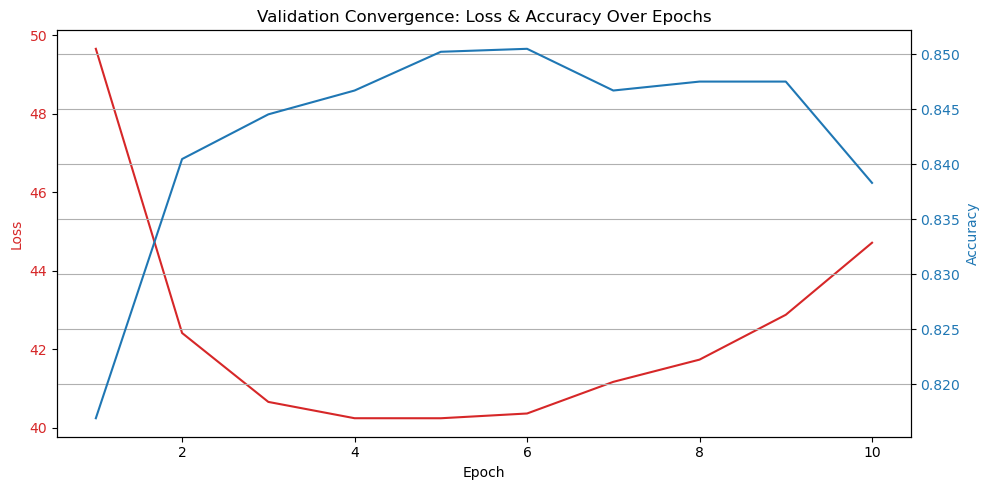

In [38]:
epochs = range(1, num_epochs + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Loss
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, val_losses, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Plot Accuracy on second y-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(epochs, val_accuracies, color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Title & Legends
plt.title("Validation Convergence: Loss & Accuracy Over Epochs")
fig.tight_layout()
plt.grid(True)
plt.show()

## Side-by-side Model Performance Comparison 

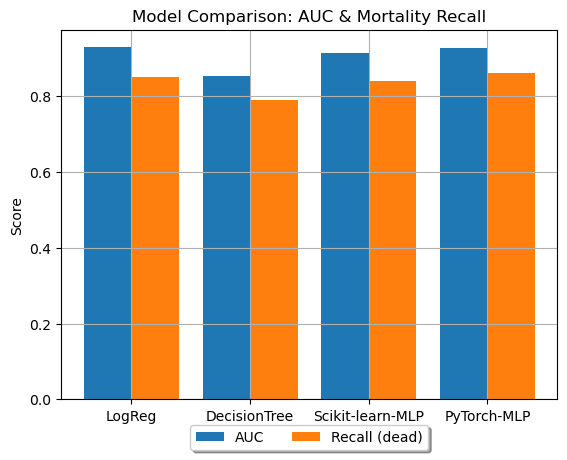

In [39]:
models = ['LogReg', 'DecisionTree', 'Scikit-learn-MLP', 'PyTorch-MLP']
auc = [0.928, 0.852, 0.914, 0.926]
recall = [0.85, 0.79, 0.84, .86]

models_length = range(len(models))
# Show grid to help with reading values
plt.grid(True)
plt.bar(models_length, auc, width=0.4, label='AUC', align='center')
plt.bar([p + 0.4 for p in models_length], recall, width=0.4, label='Recall (dead)', align='center')
plt.xticks([p + 0.2 for p in models_length], models)
plt.ylabel("Score")
plt.title("Model Comparison: AUC & Mortality Recall")
# Move legend to the bottom
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()